In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange


# Diffusion models

## Intro
For every object in our data distribution $\mu^i \sim p_{\text{data}}(\mu)$ we define the noising process as
$$q_t^i(x) = \mathcal{N}(x|\alpha_t\mu^i,\sigma_t^2)\,.$$
The important part about defining this process is that we know the vector field satisfying the corresponding continuity equation
$$v_t^i(x) = (x-\alpha_t\mu^i)\frac{\partial}{\partial t}\log\sigma_t + \frac{\partial\alpha_t}{\partial t}\mu^i\,.$$
For the entire dataset we can write down the following marginal density
$$q_t(x) = \int \mathcal{N}(x|\alpha_t\mu,\sigma_t^2)p_{\text{data}}(\mu)d\mu\,,$$
and we can write down the loss for the vector field as
$$\text{Loss} = \frac{1}{N}\sum_{i=1}^N\int dt\;\int dx\;\Vert v_t(x;\theta) - v_t^i(x)\Vert^2\,,$$
where $\theta$ are the parameters of our model.

After training, we can simulate the process (generate data) via the following ODE
$$\frac{dx}{dt} = v_t(x)\,,\;\;\; v_t(x) = x\frac{\partial}{\partial t}\log\alpha_t - \beta_t\nabla_x\log q_t(x)\,,\;\;\beta_t = \sigma_t^2\frac{\partial}{\partial t}\log \frac{\sigma_t}{\alpha_t}\,,$$
or SDE
$$dx = (v_t(x) + \xi_t\nabla_x\log q_t(x))\cdot dt + \sqrt{2\xi_t}dW_t\,.$$

## Data Generation

$p_{\text{data}}(\mu)$ is just a mixture of four Gaussians. Then we define the noising process
$$q_t^i(x) = \mathcal{N}(x|\alpha_t\mu^i,\sigma_t^2)\,.$$
See code for $\alpha_t, \sigma_t$.
The plots represent samples from the following marginals for different times $t$
$$q_t(x) = \int \mathcal{N}(x|\alpha_t\mu,\sigma_t^2)p_{\text{data}}(\mu)d\mu\,.$$

This function generates synthetic 2D data from a mixture of 4 Gaussians, centered on the four corners of a 2x2 grid: 

$$ x \textasciitilde \Sigma_{k=1}^4 \pi_k \cdot \mathcal{N}(\mu_k, \Sigma_k)  $$

- $\pi = \dfrac{1}{4}$: Equal probability for each Gaussian
- $\mu_k$: cluster centers (2D Coordinates)
- $\Sigma_k = \sigma^2 I$: same isotropic variance for all

#### 1. Discrete Sampling of Cluster Centers
First, we sample from 4 discrete centers: (0,0), (0,1), (1,0), (1,1).

Start with grid coordinates:
\begin{aligned}
\mathcal{C} = \{ (0,0), (0,1), (1,0), (1,1) \}
\end{aligned}
Each point is a mean $\mu_k$ for the $k$-th Gaussian.

#### 2. Scale and shift the centers
To make clusters spread out visually:
- \bold{Scale}: Multiply coordinates by a factor (e.g 3)
- \bold{Shift}: Center around origin (e.g subtract 1.5)

\begin{aligned}
  \mu_k = 3 \cdot (i,j) - 1.5 
\end{aligned} 

This maps the grid to:
\begin{aligned}
\{ (−1.5,−1.5),(−1.5,1.5),(1.5,−1.5),(1.5,1.5) \}
\end{aligned}

#### 3. Sample From Each Gaussian
For a chosen center $\mu_k$ sample:
\begin{aligned}
   x \textasciitilde \mathcal{N}(\mu_k, \sigma^2 I)
\end{aligned}
This generates points clustered around that center with isotropic spread



In [27]:

def sample_data(bs):
  """
  Generates sample data based on a uniform distribution over 4 cluster centers.

  Args:
    bs (int): The batch size.

  Returns:
    torch.Tensor: A tensor of shape (bs, 2) representing the sampled data.
  """
  x_1 = torch.randint(0, 2, (bs, 2)).float()
  x_1 = 3 * (x_1 - 0.5)
  x_1 += 4e-1 * torch.randn_like(x_1)
  return x_1

In [28]:
# Time and beta parameters for the diffusion process
t_0, t_1 = 0.0, 1.0
beta_0 = 0.1
beta_1 = 20.0

#### 🎯Signal Decay Schedule 

This lambda function defines the logarithm of the <strong>signal coefficient</strong> $\log \alpha(t)$, controlling how much of the original data $x_0$ is preserved as time increases.

It is derived from the <strong>integral of beta(t)</strong>:

\begin{aligned}
\log \alpha(t) = - \int_0^t \beta(s) ds
\end{aligned}

Used in the forward diffusion process where clean data is gradually noised over time:
\begin{aligned}
x_t = \alpha_t x_0 + \sigma_t \cdot \epsilon
\end{aligned}

This expression ensures a smooth decay of the signal component over time.

1. Assume a Linear Beta Schedule:

The function assumes that $\beta(t)$ is linearly increasing between two values:

$$
\beta(t)-\beta_0+t\left(\beta_1-\beta_0\right)
$$


This is a standard linear schedule used in many diffusion models (e.g., DDPM).
2. Substitute into the Integral

You want:

$$
\log \alpha(t)=-\int_0^t \beta(s) d s=-\int_0^t\left(\beta_0+s\left(\beta_1-\beta_0\right)\right) d s
$$

3. Evaluate the Integral

Split the integral:

$$
\log \alpha(t)=-\left[\int_0^t \beta_0 d s+\int_0^t s\left(\beta_1-\beta_0\right) d s\right]
$$


Compute each term:
- $\int_0^t \beta_0 d s-\beta_0 t$
- $\int_0^t s\left(\beta_1-\beta_0\right) d s-\frac{1}{2}\left(\beta_1-\beta_0\right) t^2$

So:

$$
\log \alpha(t)=-\beta_0 t-\frac{1}{2}\left(\beta_1-\beta_0\right) t^2
$$


Now factor to match the lambda:

$$
\log \alpha(t)=-0.5 t \beta_0-0.25 t^2\left(\beta_1-\beta_0\right)
$$


That's exactly what the code is doing!

In [29]:
def log_alpha(t):
  """
  Calculates the log of the alpha term in the diffusion process.

  Args:
    t (torch.Tensor or float): The time step.

  Returns:
    torch.Tensor: The log of alpha_t.
  """
  t_tensor = torch.as_tensor(t, dtype=torch.float32)
  return -0.5 * t_tensor * beta_0 - 0.25 * t_tensor ** 2 * (beta_1 - beta_0)

#### 📌log_sigma(t) - Noise Growth Schedule

This is a simplified function that grows linearly in log space. In full diffusion models, it would be:

\begin{aligned}
\log \sigma(t) = \log \sqrt{1-\alpha(t)^2}
\end{aligned}
In this case, it models how much noise is injected into the system at time t.

In [30]:
def log_sigma(t):
  """
  Calculates the log of the sigma term in the diffusion process.

  Args:
    t (torch.Tensor or float): The time step.

  Returns:
    torch.Tensor: The log of sigma_t.
  """
  # Ensure t is a tensor for torch.log
  t_tensor = torch.as_tensor(t, dtype=torch.float32)
  return torch.log(t_tensor)

#### 📌 dlog_alphadt and dlog_sigmadt – Time Derivatives

These represent $\dfrac{d}{dt} \log \alpha (t)$ and $\dfrac{d}{dt} \log \sigma(t)$ which indicate how rapidly signal decays and noise increases over time.

These are used to compute the <strong>diffusion rate </strong> $\beta(t)$, which appears in the SDE formulation of diffusion process.


In [31]:
def dlog_alphadt(t):
    """
    Computes the derivative of log_alpha with respect to t.

    Args:
        t (float or torch.Tensor): The time step.

    Returns:
        torch.Tensor: The derivative of log_alpha.
    """
    t_tensor = torch.tensor(t, dtype=torch.float32, requires_grad=True)
    log_alpha_val = log_alpha(t_tensor)
    log_alpha_val.backward()
    return t_tensor.grad

def dlog_sigmadt(t):
    """
    Computes the derivative of log_sigma with respect to t.

    Args:
        t (float or torch.Tensor): The time step.

    Returns:
        torch.Tensor: The derivative of log_sigma.
    """
    t_tensor = torch.tensor(t, dtype=torch.float32, requires_grad=True)
    log_sigma_val = log_sigma(t_tensor)
    log_sigma_val.backward()
    return t_tensor.grad

#### 📌 beta(t) – Noise Rate Schedule
Our $\beta(t)$ is defined by:
\begin{aligned}
 \beta(t) = \sigma_t \dfrac{d}{dt} \log (\dfrac{\sigma_t}{\alpha_t})
\end{aligned}
This equation gives the rate of variance increase in the forward process. It's a manually defined schedule, shaped as a quadratic function of t.

This controls how fast noise is added to the data - critical for defining the trajectory of both forward and reverse diffusion.

We define $\beta(t)$: 
$$
\log \beta(t)= 1 + \dfrac{1}{2} \cdot \beta_0 t - \frac{1}{2}\left(\beta_1-\beta_0\right) t^2
$$


In [32]:
def beta(t):
  """
  Calculates the beta term, which is related to the diffusion schedule.

  Args:
    t (torch.Tensor or float): The time step.

  Returns:
    torch.Tensor or float: The value of beta_t.
  """
  return (1 + 0.5*t*beta_0 + 0.5*t**2*(beta_1-beta_0))

#### 📌 q_t(key, data, t) – Forward Diffusion Sampling

This function implements the forward diffusion equation:

$$x_t = \alpha_t x_0 + \sigma_t \epsilon, \quad \epsilon \textasciitilde \mathcal{N}(0, I)$$

- $\alpha_t$: Signal decay
- $\sigma_t$: Noise increase
- $x_0$: Original data
- $x_t$: Noised data at time t

This function is the core of the forward process in diffusion models, simulating how data is progressively corrupted by Gaussian noise — a key step in training denoising models or learning score functions.


In [33]:
def q_t(data, t):
  """
  Performs the forward diffusion process (q_t) to add noise to the data.

  Args:
    data (torch.Tensor): The input data tensor.
    t (float): The time step.

  Returns:
    tuple[torch.Tensor, torch.Tensor]: A tuple containing the noise and the noisy data.
  """
  eps = torch.randn_like(data)
  x_t = torch.exp(log_alpha(t)) * data + torch.exp(log_sigma(t)) * eps
  return eps, x_t

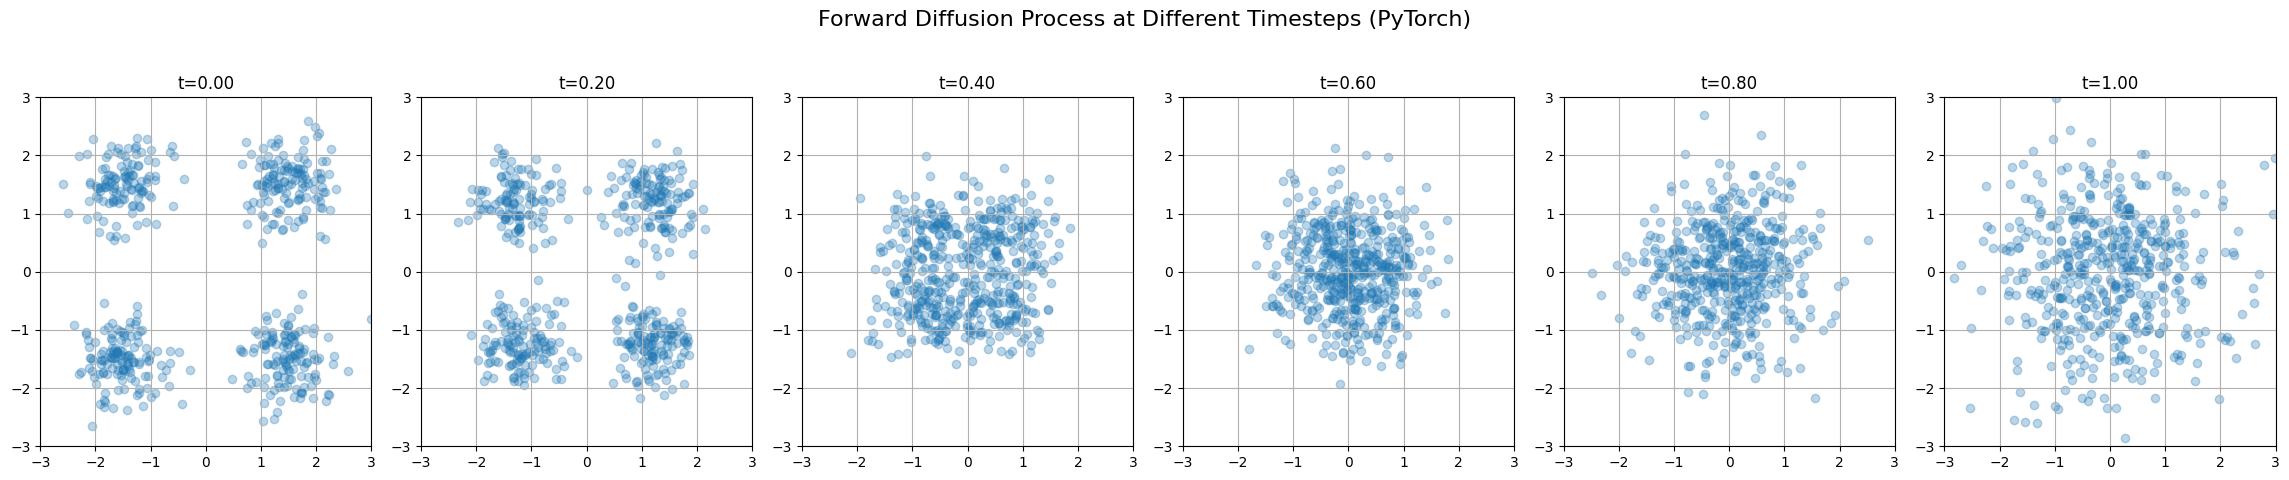

In [34]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

bs = 512
t_axis = np.linspace(0.001, 1.0, 6) # Start from a small non-zero value for log_sigma

plt.figure(figsize=(23, 5))
for i, t_val in enumerate(t_axis):
  plt.subplot(1, len(t_axis), i + 1)
  
  # Generate data and apply the forward process
  data_sample = sample_data(bs)
  _, x_t = q_t(data_sample, t_val)
  
  # Scatter plot the results
  plt.scatter(x_t[:, 0].numpy(), x_t[:, 1].numpy(), alpha=0.3)
  plt.title(f't={t_val:.2f}')
  plt.xlim(-3, 3)
  plt.ylim(-3, 3)
  plt.grid(True)

plt.suptitle("Forward Diffusion Process at Different Timesteps (PyTorch)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### 🧠Intuition: Why 4 Gaussians "merge"

Each sample, from one of the Gaussians, is diffused independently

- But the diffusion process acts identically on all points.
- As noise increases, the structure between clusters disappears.
- The plot shows that all 4 clusters gradually spread and overlap — eventually forming an approximate isotropic Gaussian blob.

📈 You are watching the GMM get corrupted into a standard Gaussian.



# 3. Why This Matters for Images (and Manifolds)

##### A. Analogy:
- Think of GMMs as simplified multimodal datasets.
- In images: different clusters = different digits, objects, classes.
- The data lies on a complex manifold (structured space).

##### B. In Diffusion Models
- The forward process destroys structure (maps manifold → noise).
- The reverse process learns to recover structure (noise → manifold).
- Your toy example shows this exactly — from multi-Gaussian to Gaussian blob.


In [35]:
class MLP(nn.Module):
    def __init__(self, num_hid, num_out):
        super(MLP, self).__init__()
        self.num_hid = num_hid
        self.num_out = num_out

        self.main = nn.Sequential(
            nn.Linear(1 + num_out, num_hid),
            nn.ReLU(),
            nn.Linear(num_hid, num_hid),
            nn.SiLU(),  # Swish activation
            nn.Linear(num_hid, num_hid),
            nn.SiLU(),  # Swish activation
            nn.Linear(num_hid, num_out)
        )

    def forward(self, t, x):
        # Concatenate time and data tensors
        h = torch.cat([t, x], dim=1)
        return self.main(h)

In [36]:
seed = 0
bs = 512
learning_rate = 2e-4
num_iterations = 20_000

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [37]:
torch.manual_seed(seed)
np.random.seed(seed)

In [38]:
sample_x = sample_data(1)
model = MLP(num_hid=512, num_out=sample_x.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print("Model Architecture:")
print(model)

Model Architecture:
MLP(
  (main): Sequential(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): SiLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): SiLU()
    (6): Linear(in_features=512, out_features=2, bias=True)
  )
)


100%|██████████| 20000/20000 [00:31<00:00, 641.07it/s]


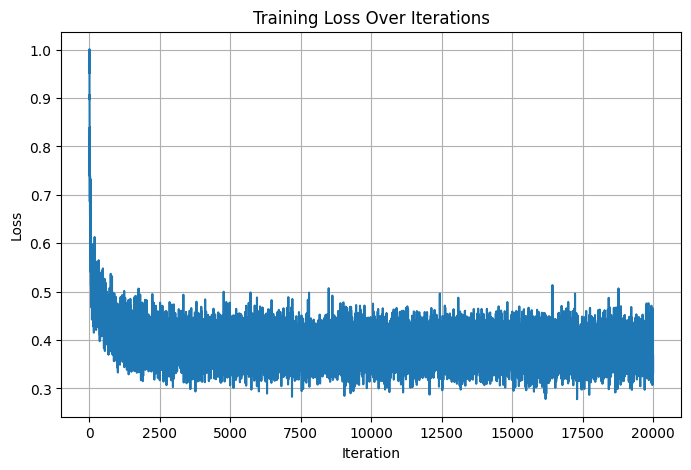

In [39]:
loss_plot = np.zeros(num_iterations)

# Use trange for a progress bar
for iter in trange(num_iterations):
    optimizer.zero_grad()

    # Sample data and time
    data = sample_data(bs).to(device)
    t = torch.rand(bs, 1, device=device) * (t_1 - 0.001) + 0.001  # Sample t from [0.001, 1.0]

    # Forward diffusion process
    eps, x_t = q_t(data, t)

    # Predict noise using the model
    predicted_noise = model(t, x_t)

    # Calculate loss
    loss = ((eps + predicted_noise) ** 2).mean()

    # Backpropagation
    loss.backward()
    optimizer.step()

    loss_plot[iter] = loss.item()

plt.figure(figsize=(8, 5))
plt.plot(loss_plot)
plt.title("Training Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

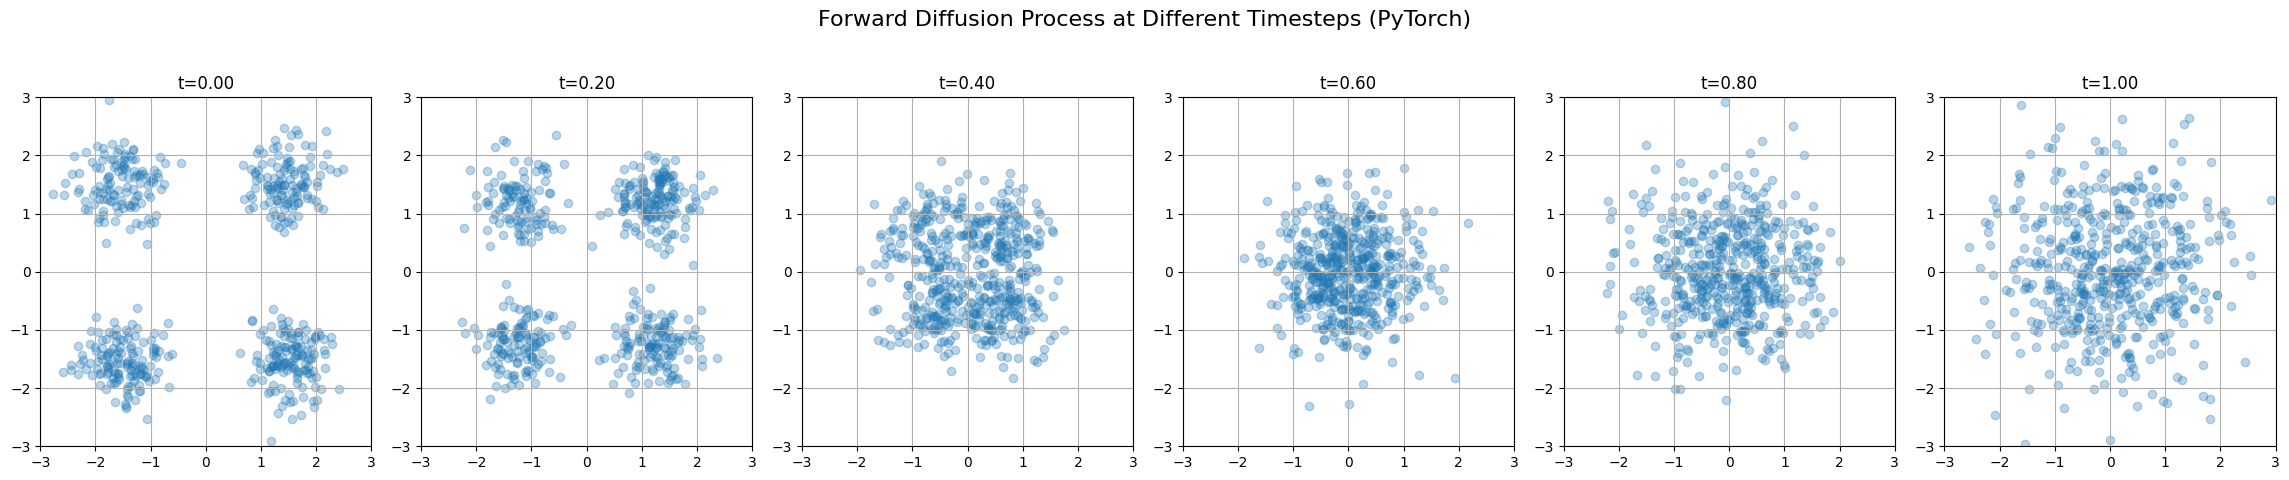

In [40]:
# --- Visualize Forward Process (optional, from before) ---
t_axis = np.linspace(0.001, 1.0, 6)
plt.figure(figsize=(23, 5))
for i, t_val in enumerate(t_axis):
    plt.subplot(1, len(t_axis), i + 1)

    data_sample = sample_data(bs)
    _, x_t = q_t(data_sample, t_val)

    plt.scatter(x_t[:, 0].numpy(), x_t[:, 1].numpy(), alpha=0.3)
    plt.title(f't={t_val:.2f}')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.grid(True)

plt.suptitle("Forward Diffusion Process at Different Timesteps (PyTorch)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Evaluation of the Trained Model

For the evaluation we simply sample from $q_{t=1}$ and propogate samples back in time according to the ODE
$$\frac{dx}{dt} = v_t(x)\,,\;\;\; v_t(x) = x\frac{\partial}{\partial t}\log\alpha_t - \beta_t\nabla_x\log q_t(x)\,,\;\;\beta_t = \sigma_t^2\frac{\partial}{\partial t}\log \frac{\sigma_t}{\alpha_t}\,,$$
or SDE
$$dx = (v_t(x) + \xi_t\nabla_x\log q_t(x))\cdot dt + \sqrt{2\xi_t}dW_t\,.$$